## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

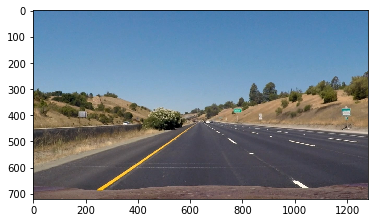

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline

from moviepy.editor import VideoFileClip
from IPython.display import HTML

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
img_exa = cv2.imread('./test_images/straight_lines1.jpg')
img_exa = cv2.cvtColor(img_exa, cv2.COLOR_BGR2RGB)
plt.imshow(img_exa)
plt.show()

nx = 9
ny = 6

In [2]:
def cal_calccalib(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[::-1],None,None)
    
    return dist, mtx, rvecs, tvecs

In [3]:
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    plt.imshow(undist)
    
    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset],
                                     [img_size[0]-offset, img_size[1]-offset],
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M




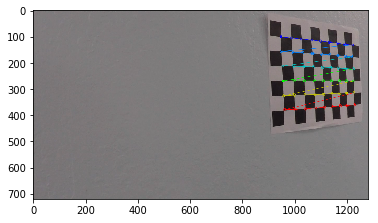

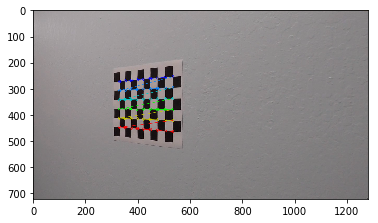

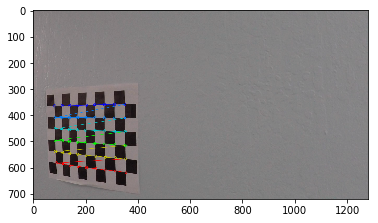

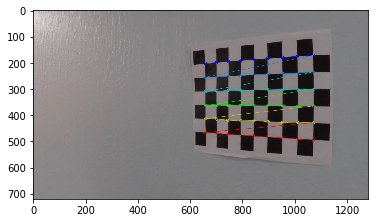

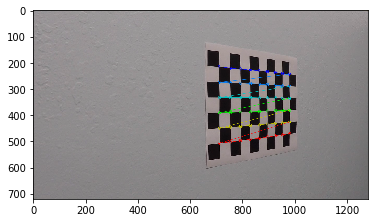

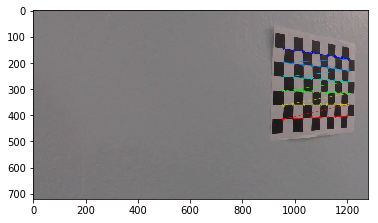

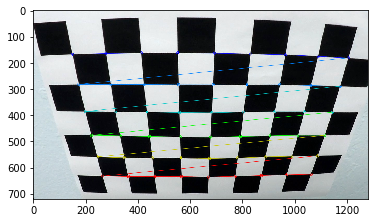

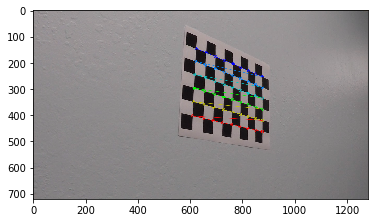

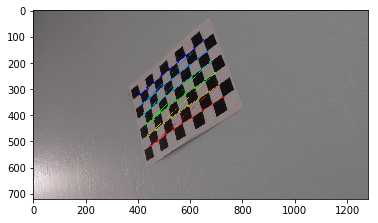

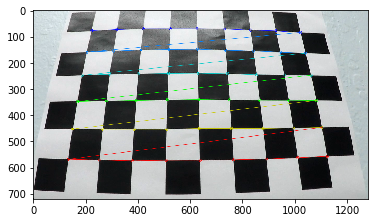

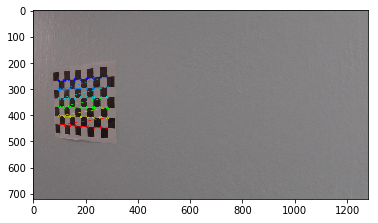

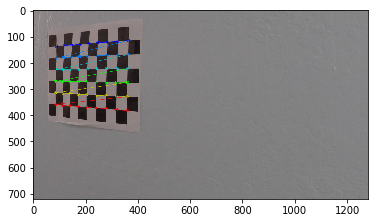

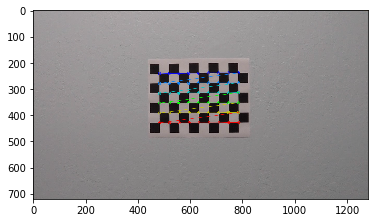

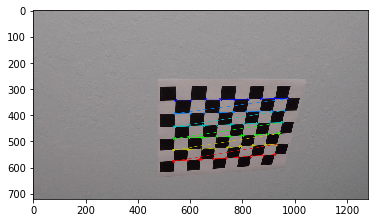

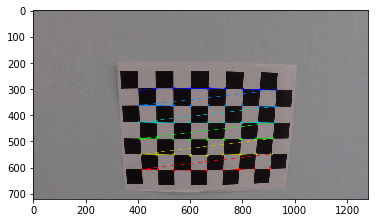

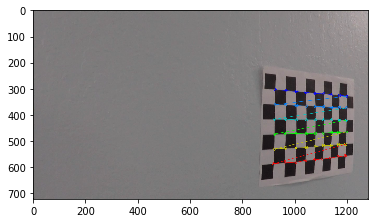

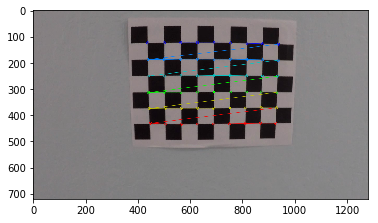

Mean Calibration
[[-0.24688572 -0.02372824 -0.00109832  0.00035104 -0.00260433]]
[[  1.15777829e+03   0.00000000e+00   6.67113866e+02]
 [  0.00000000e+00   1.15282230e+03   3.86124658e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


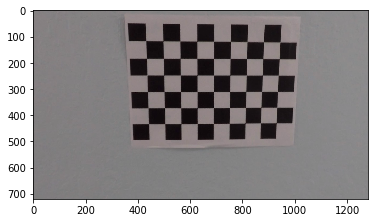

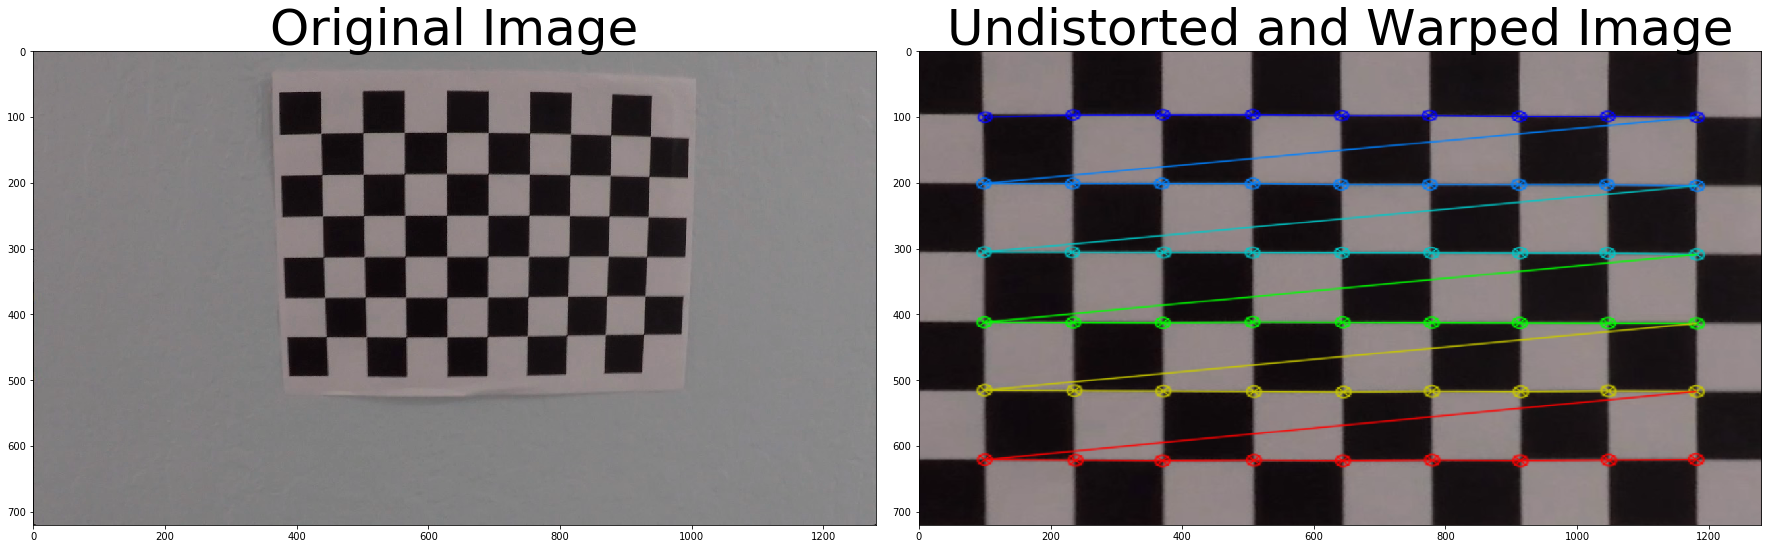

In [4]:
def mean_calib(images,objp,objpoints,imgpoints,nx,ny):
    distm = 0
    mtxm = 0
    found = 0
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        img_draw = img.copy()
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
        
        # If found, add object points, image points
        if ret == True:
            found = found + 1
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img_draw = cv2.drawChessboardCorners(img_draw, (nx,ny), corners, ret)
            plt.imshow(img_draw, cmap = 'gray')
            plt.show()
    
    dist, mtx, rvecs, tvecs = cal_calccalib(gray, objpoints, imgpoints)
    
    top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(top_down)
    ax2.set_title('Undistorted and Warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
            
    return dist, mtx

dist, mtx = mean_calib(images,objp,objpoints,imgpoints,nx,ny)

print("Mean Calibration")
print(dist)
print(mtx)

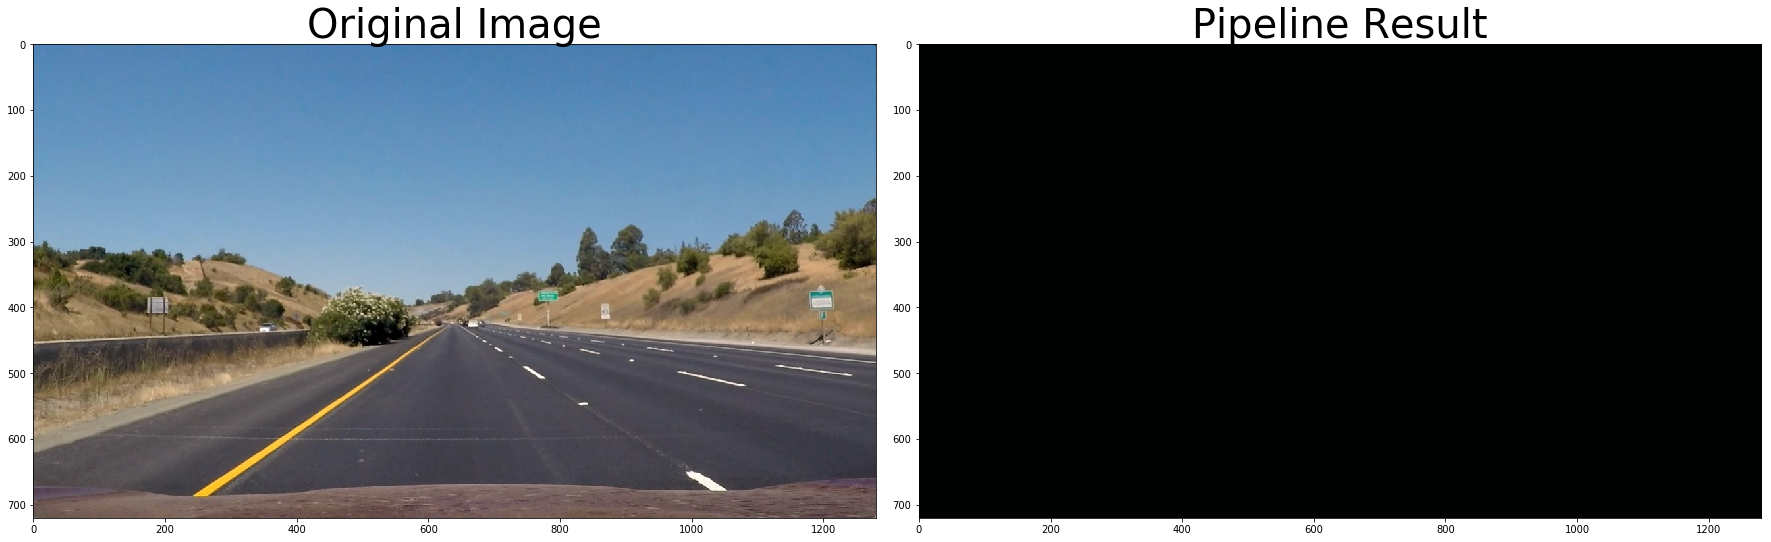

In [5]:
s_thresh=(0, 255)
sx_thresh=(0, 255)

def pipeline(img):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary
    
result = pipeline(img_exa)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img_exa)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

NameError: name 'process_image' is not defined